Author: Eric Chandler <echandler@uchicago.edu>

Description: Trying to write some computer code to make sense of the Durlauf-Seshadri paper

## Goals
Implement the Durlauf-Seshadri model as a simulation, reproduce the expected stylized facts, identify causal mechanism, test implications of extending model or relaxing certain assumptions.
## 
The paper's main arguments are 1) segregation causes and aggravates inequality 2) and that inequality decreases subsequent generations' mobility.
## Stylized Facts
* intertemporal great gadby curve emerges
* permanent segregation without explicit poverty/affluence traps
## Model Structure
* income is certain and depends on child human capital
* only two periods of life (child/get capital, adult/get income)
* local public finance of schools
* students in same school gain same amount of capital from school
* parents prefer more affluent, larger neighborhoods
* inequality increases segregation

## Key Assumptions
* local public finance of schools
* no marriage or inter-family income sharing
* one child, no elders, no population growth or shrink
* no direct parental investment (only via neighborhood)
* parental utility depends on child expected income, not on child expected utility or human capital
* no credit constraint
## Further Directions
* alternative mechanisms for mobility:
    * credit constraints
    * productivity of parent capital investment in child depends on parent capital level
    * other ways for heterogenous AR
* peer effects in capital development
* role model effects in capital development
* alternative utility functions:
    * child expected utility (implicitly includes dynasty income after t+1)
    * child human capital
* heterogeneous preferences in utility function: what general conditions allow equilibriums?




## Model
cross-sectional inequality -> neighborhood differences

segregation:= increasing function of cross-sectional inequality

mobility := parental input + neighborhood quality

agents in firm/school split earninge evenly. no additional benefits for most productive person.

### Optional
* assortive matching of workers by skill because its more efficient overall
* assortive matching of students to schools because its more efficient overall
* spatial segregation




In [3]:
from sim import Sim
import numpy as np

## Explore Single Config Spaces

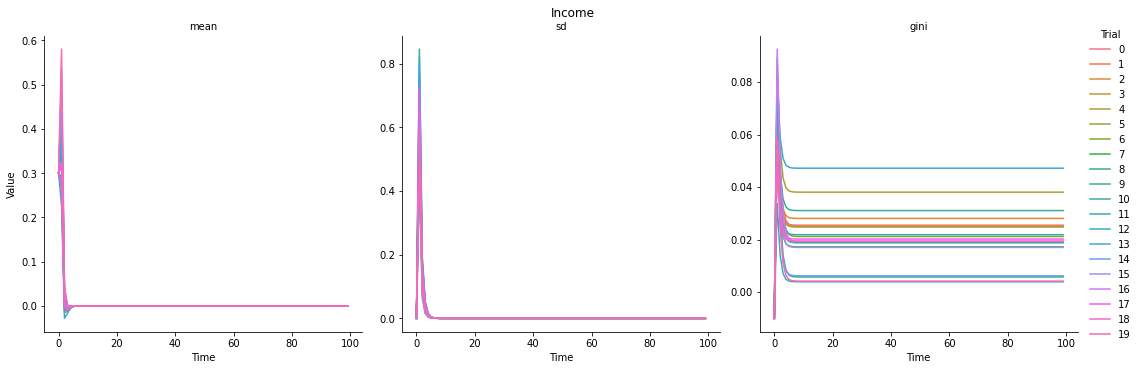

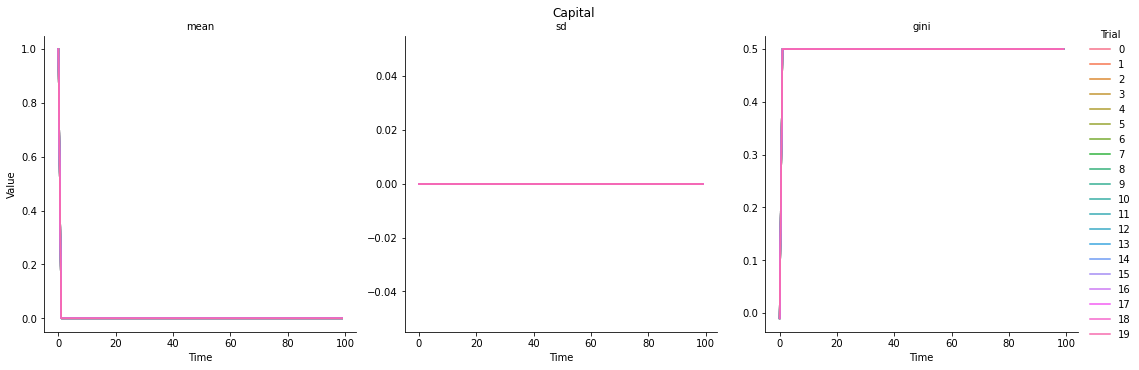

In [6]:
sim = Sim()

sim.set('PARENTAL_INVESTMENT_COEF', .30)
sim.set('SKILL_FROM_NEIGHBOR_INCOME', .30)
sim.set('SKILL_FROM_PARENT_INCOME', .30)
sim.set('CAPITAL_EFFICIENCY', 1.5)
sim.set('INCOME_NOISE_ADDITIVE', 0)
sim.set('INCOME_NOISE_AUTOREG', 0)
sim.set('TAX_RATE', .7)


res = sim.run(20)
res.income.plot()
res.human_capital.plot()

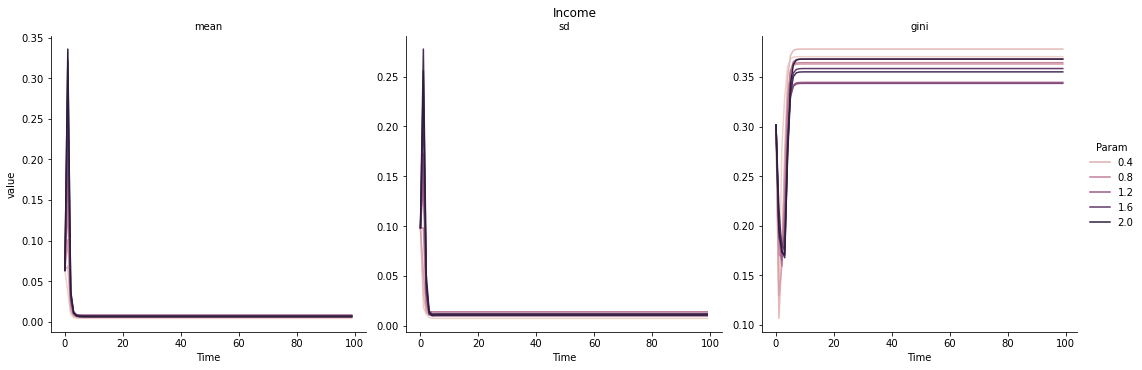

In [51]:
sim = Sim()
sim.set('PARENTAL_INVESTMENT_COEF', .2)
sim.set('SKILL_FROM_NEIGHBOR_INCOME', 1.5)
sim.set('SKILL_FROM_PARENT_INCOME', 0)
sim.set('CAPITAL_EFFICIENCY', 10)
sim.set('INCOME_NOISE_ADDITIVE', 0)
sim.set('INCOME_NOISE_AUTOREG', 0)
sim.set('TAX_RATE', .8)
res = sim.run_sweep('CAPITAL_EFFICIENCY', np.linspace(.1,2,10), ntrials=10)
res.income.plot()